# GloBUS 

Corresponding Author: Jerry Song; jerrysong0128@gmail.com

This project serves as an interactive guide to the practical implementation of Global Dynamic Building Sand Model (GloBUS).

```cmd
Software version: Python 3.7

This code transfers the social economic development in 26 global regions into the use of sand for the production of building concrete and glass. For the original code & latest updates, see: https:/github.com/Zh-xy/GloBus
The building material model is based on the BUMA model developed by Sebastiaan Deetman (https:/github.com/SPDeetman/BUMA) and the GloBUME model by Xiaoyang Zhong (DOI: 10.5281/zenodo.5171943)
The dynamic stock model is based on the ODYM model developed by Stefan Pauliuk, Uni Freiburg, Germany. For the original code & latest updates, see: https:/github.com/IndEcol/ODYM

@author: Xiaoyang Zhong; x.zhong@cml.leidenuniv.nl
         Sebastiaan Deetman; deetman@cml.leidenuniv.nl

contributions from: Glenn Aguilar; Sylvia Marinova

*NOTE: Insert location of the GloBUS-main folder in 'dir_path' (line 26) to run the code.

```
<div style="text-align: center;">
    <img src="./tools/fig/flow_chart.png" alt="My Image: GCAM_MFA" title="GCAM_MFA" width="800"/>
</div>


In [1]:
import sys
sys.path.append('./tools')
import plot_tools

In [2]:
#%% GENERAL SETTING & STATEMENTS
import pandas as pd
import numpy as np
import os
import ctypes     
import math

# set current directory
dir_path = "./"
os.chdir(dir_path)   

# Set general constants
regions = 26        #26 IMAGE regions
res_building_types = 4  #4 residential building types: detached, semi-detached, appartments & high-rise 
area = 2            #2 areas: rural & urban
materials = 7       #2 materials: Concrete, Glass
inflation = 1.2423  # gdp/cap inflation correction between 2005 (IMAGE data) & 2016 (commercial calibration) according to https:/www.bls.gov/data/inflation_calculator.htm

# Set Flags for sensitivity analysis
flag_alpha = 0      # switch for the sensitivity analysis on alpha, if 1 the maximum alpha is 10% above the maximum found in the data
flag_ExpDec = 0     # switch to choose between Gompertz and Exponential Decay function for commercial floorspace demand (0 = Gompertz, 1 = Expdec)
flag_Normal = 0     # switch to choose between Weibull and Normal lifetime distributions (0 = Weibull, 1 = Normal)
flag_Mean   = 0     # switch to choose between material intensity settings (0 = regular regional, 1 = mean, 2 = high, 3 = low, 4 = median)

In [3]:
# Load Population, Floor area, and Service value added (SVA) Database csv-files
pop = pd.read_csv('files_population/pop.csv', index_col = [0])                # Pop; unit: million of people; meaning: global population (over time, by region)             
rurpop = pd.read_csv('files_population/rurpop.csv', index_col = [0])          # rurpop; unit: %; meaning: the share of people living in rural areas (over time, by region)
housing_type = pd.read_csv('files_population/Housing_type.csv')               # Housing_type; unit: %; meaning: the share of the NUMBER OF PEOPLE living in a particular building type (by region & by area) 
floorspace = pd.read_csv('files_floor_area/res_Floorspace.csv')               # Floorspace; unit: m2/capita; meaning: the average m2 per capita (over time, by region & area)
floorspace = floorspace[floorspace.Region != regions + 1]                     # Remove empty region 27
avg_m2_cap = pd.read_csv('files_floor_area/Average_m2_per_cap.csv')           # Avg_m2_cap; unit: m2/capita; meaning: average square meters per person (by region & area (rural/urban) & building type) 
sva_pc_2005 = pd.read_csv('files_GDP/sva_pc.csv', index_col = [0])
sva_pc = sva_pc_2005 * inflation                                              # we use the inflation corrected SVA to adjust for the fact that IMAGE provides gdp/cap in 2005 US$

# load material density data csv-files

building_materials = pd.read_csv('files_material_density/Building_materials.csv')   # Building_materials; unit: kg/m2; meaning: the average material use per square meter (by building type, by region & by area)
materials_commercial = pd.read_csv('files_material_density/materials_commercial.csv') # 2 building materials in 4 commercial building types; unit: kg/m2; meaning: the average material use per square meter (by commercial building type) 

# Load fitted regression parameters for comercial floor area estimate
if flag_alpha == 0:
    gompertz = pd.read_csv('files_floor_area/files_commercial/Gompertz_parameters.csv', index_col = [0])
else:
    gompertz = pd.read_csv('files_floor_area/files_commercial/Gompertz_parameters_alpha.csv', index_col = [0])


# Ensure full time series  for pop & rurpop (interpolation, some years are missing)
rurpop2 = rurpop.reindex(list(range(1970,2061,1))).interpolate()
pop2 = pop.reindex(list(range(1970,2061,1))).interpolate()

# Remove 1st year, to ensure same Table size as floorspace data (from 1971)
pop2 = pop2.iloc[1:]
rurpop2 = rurpop2.iloc[1:]

# pre-calculate urban population
urbpop = 1 - rurpop2                                                           # urban population is 1 - the fraction of people living in rural areas (rurpop)
        
# Restructure the tables to regions as columns; for floorspace
floorspace_rur = floorspace.pivot(index = "t", columns = "Region", values = "Rural")
floorspace_urb = floorspace.pivot(index = "t", columns = "Region", values = "Urban")

# Restructuring for square meters (m2/cap)
avg_m2_cap_urb = avg_m2_cap.loc[avg_m2_cap['Area'] == 'Urban'].drop('Area', axis=1).T  # Remove area column & Transpose
avg_m2_cap_urb.columns = list(map(int,avg_m2_cap_urb.iloc[0]))                      # name columns according to the row containing the region-labels
avg_m2_cap_urb2 = avg_m2_cap_urb.drop(['Region'])                                 # Remove idle row 

avg_m2_cap_rur = avg_m2_cap.loc[avg_m2_cap['Area'] == 'Rural'].drop('Area', axis=1).T  # Remove area column & Transpose
avg_m2_cap_rur.columns = list(map(int,avg_m2_cap_rur.iloc[0]))                      # name columns according to the row containing the region-labels
avg_m2_cap_rur2 = avg_m2_cap_rur.drop(['Region'])                                 # Remove idle row 

# Restructuring for the Housing types (% of population living in them)
housing_type_urb = housing_type.loc[housing_type['Area'] == 'Urban'].drop('Area', axis=1).T  # Remove area column & Transpose
housing_type_urb.columns = list(map(int,housing_type_urb.iloc[0]))                      # name columns according to the row containing the region-labels
housing_type_urb2 = housing_type_urb.drop(['Region'])                                 # Remove idle row 

housing_type_rur = housing_type.loc[housing_type['Area'] == 'Rural'].drop('Area', axis=1).T  # Remove area column & Transpose
housing_type_rur.columns = list(map(int,housing_type_rur.iloc[0]))                      # name columns according to the row containing the region-labels
housing_type_rur2 = housing_type_rur.drop(['Region'])                                 # Remove idle row 



# COMMERCIAL building space demand (stock) calculated from Gomperz curve

In [4]:
#%% COMMERCIAL building space demand (stock) calculated from Gomperz curve (fitted, using separate regression model)

# Select gompertz curve paramaters for the total commercial m2 demand (stock)
alpha = gompertz['All']['a'] if flag_ExpDec == 0 else 25.601
beta =  gompertz['All']['b'] if flag_ExpDec == 0 else 28.431
gamma = gompertz['All']['c'] if flag_ExpDec == 0 else 0.0415

# find the total commercial m2 stock (in Millions of m2)
commercial_m2_cap = pd.DataFrame(index = range(1971,2061), columns = range(1,27))
for year in range(1971,2061):
    for region in range(1,27):
        if flag_ExpDec == 0:
            commercial_m2_cap[region][year] = alpha * math.exp(-beta * math.exp((-gamma/1000) * sva_pc[str(region)][year]))
        else:
            commercial_m2_cap[region][year] = max(0.542, alpha - beta * math.exp((-gamma/1000) * sva_pc[str(region)][year]))

# Subdivide the total across Offices, Retail+, Govt+ & Hotels+
commercial_m2_cap_office = pd.DataFrame(index = range(1971,2061), columns = range(1,27))    # Offices
commercial_m2_cap_retail = pd.DataFrame(index = range(1971,2061), columns = range(1,27))    # Retail & Warehouses
commercial_m2_cap_hotels = pd.DataFrame(index = range(1971,2061), columns = range(1,27))    # Hotels & Restaurants
commercial_m2_cap_govern = pd.DataFrame(index = range(1971,2061), columns = range(1,27))    # Hospitals, Education, Government & Transportation

minimum_com_office = 25
minimum_com_retail = 25
minimum_com_hotels = 25
minimum_com_govern = 25

for year in range(1971,2061):
    for region in range(1,27):
        
        # get the square meter per capita floorspace for 4 commercial applications
        office = gompertz['Office']['a'] * math.exp(-gompertz['Office']['b'] * math.exp((-gompertz['Office']['c']/1000) * sva_pc[str(region)][year]))
        retail = gompertz['Retail+']['a'] * math.exp(-gompertz['Retail+']['b'] * math.exp((-gompertz['Retail+']['c']/1000) * sva_pc[str(region)][year]))
        hotels = gompertz['Hotels+']['a'] * math.exp(-gompertz['Hotels+']['b'] * math.exp((-gompertz['Hotels+']['c']/1000) * sva_pc[str(region)][year]))
        govern = gompertz['Govt+']['a'] * math.exp(-gompertz['Govt+']['b'] * math.exp((-gompertz['Govt+']['c']/1000) * sva_pc[str(region)][year]))

        #calculate minimum values for later use in historic tail(Region 20: China @ 134 $/cap SVA)
        minimum_com_office = office if office < minimum_com_office else minimum_com_office      
        minimum_com_retail = retail if retail < minimum_com_retail else minimum_com_retail
        minimum_com_hotels = hotels if hotels < minimum_com_hotels else minimum_com_hotels
        minimum_com_govern = govern if govern < minimum_com_govern else minimum_com_govern
        
        # Then use the ratio's to subdivide the total commercial floorspace into 4 categories      
        commercial_sum = office + retail + hotels + govern
        
        commercial_m2_cap_office[region][year] = commercial_m2_cap[region][year] * (office/commercial_sum)
        commercial_m2_cap_retail[region][year] = commercial_m2_cap[region][year] * (retail/commercial_sum)
        commercial_m2_cap_hotels[region][year] = commercial_m2_cap[region][year] * (hotels/commercial_sum)
        commercial_m2_cap_govern[region][year] = commercial_m2_cap[region][year] * (govern/commercial_sum)

# Add historic tail

In [5]:
#%% Add historic tail (1720-1970) + 100 yr initial -----------------------------------------------------------

# load historic population development
hist_pop = pd.read_csv('files_initial_stock/hist_pop.csv', index_col = [0])  # initial population as a percentage of the 1970 population; unit: %; according to the Maddison Project Database (MPD) 2018 (Groningen University)

# Determine the historical average global trend in floorspace/cap  & the regional rural population share based on the last 10 years of IMAGE data
floorspace_urb_trend_by_region = [0 for j in range(0,26)]
floorspace_rur_trend_by_region = [0 for j in range(0,26)]
rurpop_trend_by_region = [0 for j in range(0,26)]
commercial_m2_cap_office_trend = [0 for j in range(0,26)]
commercial_m2_cap_retail_trend = [0 for j in range(0,26)]
commercial_m2_cap_hotels_trend = [0 for j in range(0,26)]
commercial_m2_cap_govern_trend = [0 for j in range(0,26)]

# For the RESIDENTIAL & COMMERCIAL floorspace: Derive the annual trend (in m2/cap) over the initial 10 years of IMAGE data
for region in range(1,27):
    floorspace_urb_trend_by_year = [0 for i in range(0,10)]
    floorspace_rur_trend_by_year = [0 for i in range(0,10)]
    commercial_m2_cap_office_trend_by_year = [0 for j in range(0,10)]    
    commercial_m2_cap_retail_trend_by_year = [0 for i in range(0,10)]   
    commercial_m2_cap_hotels_trend_by_year = [0 for j in range(0,10)]
    commercial_m2_cap_govern_trend_by_year = [0 for i in range(0,10)]
    
    # Get the growth by year (for the first 10 years)
    for year in range(1970,1980):
        floorspace_urb_trend_by_year[year-1970] = floorspace_urb[region][year+1]/floorspace_urb[region][year+2]
        floorspace_rur_trend_by_year[year-1970] = floorspace_rur[region][year+1]/floorspace_rur[region][year+2]
        commercial_m2_cap_office_trend_by_year[year-1970] = commercial_m2_cap_office[region][year+1]/commercial_m2_cap_office[region][year+2]
        commercial_m2_cap_retail_trend_by_year[year-1970] = commercial_m2_cap_retail[region][year+1]/commercial_m2_cap_retail[region][year+2] 
        commercial_m2_cap_hotels_trend_by_year[year-1970] = commercial_m2_cap_hotels[region][year+1]/commercial_m2_cap_hotels[region][year+2]
        commercial_m2_cap_govern_trend_by_year[year-1970] = commercial_m2_cap_govern[region][year+1]/commercial_m2_cap_govern[region][year+2]
        
    rurpop_trend_by_region[region-1] = ((1 - (rurpop[str(region)][1980]/rurpop[str(region)][1970]))/10)*100
    floorspace_urb_trend_by_region[region-1] = sum(floorspace_urb_trend_by_year)/10
    floorspace_rur_trend_by_region[region-1] = sum(floorspace_rur_trend_by_year)/10
    commercial_m2_cap_office_trend[region-1] = sum(commercial_m2_cap_office_trend_by_year)/10
    commercial_m2_cap_retail_trend[region-1] = sum(commercial_m2_cap_retail_trend_by_year)/10
    commercial_m2_cap_hotels_trend[region-1] = sum(commercial_m2_cap_hotels_trend_by_year)/10
    commercial_m2_cap_govern_trend[region-1] = sum(commercial_m2_cap_govern_trend_by_year)/10

# Average global annual decline in floorspace/cap in %, rural: 1%; urban 1.2%;  commercial: 1.26-2.18% /yr   
floorspace_urb_trend_global = (1 - (sum(floorspace_urb_trend_by_region)/26))*100              # in % decrease per annum
floorspace_rur_trend_global = (1 - (sum(floorspace_rur_trend_by_region)/26))*100              # in % decrease per annum
commercial_m2_cap_office_trend_global = (1 - (sum(commercial_m2_cap_office_trend)/26))*100    # in % decrease per annum
commercial_m2_cap_retail_trend_global = (1 - (sum(commercial_m2_cap_retail_trend)/26))*100    # in % decrease per annum
commercial_m2_cap_hotels_trend_global = (1 - (sum(commercial_m2_cap_hotels_trend)/26))*100    # in % decrease per annum
commercial_m2_cap_govern_trend_global = (1 - (sum(commercial_m2_cap_govern_trend)/26))*100    # in % decrease per annum

# define historic floorspace (1820-1970) in m2/cap
floorspace_urb_1820_1970 = pd.DataFrame(index = range(1820,1971), columns = floorspace_urb.columns)
floorspace_rur_1820_1970 = pd.DataFrame(index = range(1820,1971), columns = floorspace_rur.columns)
rurpop_1820_1970 = pd.DataFrame(index = range(1820,1971), columns = rurpop.columns)
pop_1820_1970 = pd.DataFrame(index = range(1820,1971), columns = pop2.columns)
commercial_m2_cap_office_1820_1970 = pd.DataFrame(index = range(1820,1971), columns = commercial_m2_cap_office.columns)
commercial_m2_cap_retail_1820_1970 = pd.DataFrame(index = range(1820,1971), columns = commercial_m2_cap_retail.columns)
commercial_m2_cap_hotels_1820_1970 = pd.DataFrame(index = range(1820,1971), columns = commercial_m2_cap_hotels.columns)
commercial_m2_cap_govern_1820_1970 = pd.DataFrame(index = range(1820,1971), columns = commercial_m2_cap_govern.columns)

# Find minumum or maximum values in the original IMAGE data (Just for residential, commercial minimum values have been calculated above)
minimum_urb_fs = floorspace_urb.values.min()    # Region 20: China
minimum_rur_fs = floorspace_rur.values.min()    # Region 20: China
maximum_rurpop = rurpop.values.max()            # Region 9 : Eastern Africa

# Calculate the actual values used between 1820 & 1970, given the trends & the min/max values
for region in range(1,regions+1):
    for year in range(1820,1971):
        # MAX of 1) the MINimum value & 2) the calculated value
        floorspace_urb_1820_1970[region][year] = max(minimum_urb_fs, floorspace_urb[region][1971] * ((100-floorspace_urb_trend_global)/100)**(1971-year))  # single global value for average annual Decrease
        floorspace_rur_1820_1970[region][year] = max(minimum_rur_fs, floorspace_rur[region][1971] * ((100-floorspace_rur_trend_global)/100)**(1971-year))  # single global value for average annual Decrease
        commercial_m2_cap_office_1820_1970[region][year] = max(minimum_com_office, commercial_m2_cap_office[region][1971] * ((100-commercial_m2_cap_office_trend_global)/100)**(1971-year))  # single global value for average annual Decrease  
        commercial_m2_cap_retail_1820_1970[region][year] = max(minimum_com_retail, commercial_m2_cap_retail[region][1971] * ((100-commercial_m2_cap_retail_trend_global)/100)**(1971-year))  # single global value for average annual Decrease
        commercial_m2_cap_hotels_1820_1970[region][year] = max(minimum_com_hotels, commercial_m2_cap_hotels[region][1971] * ((100-commercial_m2_cap_hotels_trend_global)/100)**(1971-year))  # single global value for average annual Decrease
        commercial_m2_cap_govern_1820_1970[region][year] = max(minimum_com_govern, commercial_m2_cap_govern[region][1971] * ((100-commercial_m2_cap_govern_trend_global)/100)**(1971-year))  # single global value for average annual Decrease
        # MIN of 1) the MAXimum value & 2) the calculated value        
        rurpop_1820_1970[str(region)][year] = min(maximum_rurpop, rurpop[str(region)][1970] * ((100 + rurpop_trend_by_region[region - 1])/100)**(1970 - year))  # average annual INcrease by region
        # just add the tail to the population (no min/max & trend is pre-calculated in hist_pop)        
        pop_1820_1970[str(region)][year] = hist_pop[str(region)][year] * pop[str(region)][1970]

urbpop_1820_1970 = 1 - rurpop_1820_1970

# To avoid full model setup in 1820 (all required stock gets built in yr 1) we assume another tail that linearly increases to the 1820 value over a 100 year time period, so 1720 = 0
floorspace_urb_1721_1820 = pd.DataFrame(index = range(1721,1820), columns = floorspace_urb.columns)
floorspace_rur_1721_1820 = pd.DataFrame(index = range(1721,1820), columns = floorspace_rur.columns)
rurpop_1721_1820 = pd.DataFrame(index = range(1721,1820), columns = rurpop.columns)
urbpop_1721_1820 = pd.DataFrame(index = range(1721,1820), columns = urbpop.columns)
pop_1721_1820 = pd.DataFrame(index = range(1721,1820), columns = pop2.columns)
commercial_m2_cap_office_1721_1820 = pd.DataFrame(index = range(1721,1820), columns = commercial_m2_cap_office.columns)
commercial_m2_cap_retail_1721_1820 = pd.DataFrame(index = range(1721,1820), columns = commercial_m2_cap_retail.columns)
commercial_m2_cap_hotels_1721_1820 = pd.DataFrame(index = range(1721,1820), columns = commercial_m2_cap_hotels.columns)
commercial_m2_cap_govern_1721_1820 = pd.DataFrame(index = range(1721,1820), columns = commercial_m2_cap_govern.columns)

for region in range(1,27):
    for time in range(1721,1820):
        #                                                        MAX(0,...) Because of floating point deviations, leading to negative stock in some cases
        floorspace_urb_1721_1820[int(region)][time]            = max(0.0, floorspace_urb_1820_1970[int(region)][1820] - (floorspace_urb_1820_1970[int(region)][1820]/100)*(1820-time))
        floorspace_rur_1721_1820[int(region)][time]            = max(0.0, floorspace_rur_1820_1970[int(region)][1820] - (floorspace_rur_1820_1970[int(region)][1820]/100)*(1820-time))
        rurpop_1721_1820[str(region)][time]                    = max(0.0, rurpop_1820_1970[str(region)][1820] - (rurpop_1820_1970[str(region)][1820]/100)*(1820-time))
        urbpop_1721_1820[str(region)][time]                    = max(0.0, urbpop_1820_1970[str(region)][1820] - (urbpop_1820_1970[str(region)][1820]/100)*(1820-time))
        pop_1721_1820[str(region)][time]                       = max(0.0, pop_1820_1970[str(region)][1820] - (pop_1820_1970[str(region)][1820]/100)*(1820-time))
        commercial_m2_cap_office_1721_1820[int(region)][time]  = max(0.0, commercial_m2_cap_office_1820_1970[region][1820] - (commercial_m2_cap_office_1820_1970[region][1820]/100)*(1820-time))
        commercial_m2_cap_retail_1721_1820[int(region)][time]  = max(0.0, commercial_m2_cap_retail_1820_1970[region][1820] - (commercial_m2_cap_retail_1820_1970[region][1820]/100)*(1820-time))
        commercial_m2_cap_hotels_1721_1820[int(region)][time]  = max(0.0, commercial_m2_cap_hotels_1820_1970[region][1820] - (commercial_m2_cap_hotels_1820_1970[region][1820]/100)*(1820-time))
        commercial_m2_cap_govern_1721_1820[int(region)][time]  = max(0.0, commercial_m2_cap_govern_1820_1970[region][1820] - (commercial_m2_cap_govern_1820_1970[region][1820]/100)*(1820-time))

# combine historic with IMAGE data here # Could be stuck here due to python version upper than 3.7. Use this line instead of the above one if you have python version upper than 3.7
# rurpop_tail                     = rurpop_1820_1970.append(rurpop2, ignore_index = False)
# urbpop_tail                     = urbpop_1820_1970.append(urbpop, ignore_index = False)
# pop_tail                        = pop_1820_1970.append(pop2, ignore_index = False)
# floorspace_urb_tail             = floorspace_urb_1820_1970.append(floorspace_urb, ignore_index = False)
# floorspace_rur_tail             = floorspace_rur_1820_1970.append(floorspace_rur, ignore_index = False)
# commercial_m2_cap_office_tail   = commercial_m2_cap_office_1820_1970.append(commercial_m2_cap_office, ignore_index = False)
# commercial_m2_cap_retail_tail   = commercial_m2_cap_retail_1820_1970.append(commercial_m2_cap_retail, ignore_index = False)
# commercial_m2_cap_hotels_tail   = commercial_m2_cap_hotels_1820_1970.append(commercial_m2_cap_hotels, ignore_index = False)
# commercial_m2_cap_govern_tail   = commercial_m2_cap_govern_1820_1970.append(commercial_m2_cap_govern, ignore_index = False)

# rurpop_tail                     = rurpop_1721_1820.append(rurpop_1820_1970.append(rurpop2, ignore_index = False), ignore_index = False)
# urbpop_tail                     = urbpop_1721_1820.append(urbpop_1820_1970.append(urbpop, ignore_index = False), ignore_index = False)
# pop_tail                        = pop_1721_1820.append(pop_1820_1970.append(pop2, ignore_index = False), ignore_index = False)
# floorspace_urb_tail             = floorspace_urb_1721_1820.append(floorspace_urb_1820_1970.append(floorspace_urb, ignore_index = False), ignore_index = False)
# floorspace_rur_tail             = floorspace_rur_1721_1820.append(floorspace_rur_1820_1970.append(floorspace_rur, ignore_index = False), ignore_index = False)
# commercial_m2_cap_office_tail   = commercial_m2_cap_office_1721_1820.append(commercial_m2_cap_office_1820_1970.append(commercial_m2_cap_office, ignore_index = False), ignore_index = False)
# commercial_m2_cap_retail_tail   = commercial_m2_cap_retail_1721_1820.append(commercial_m2_cap_retail_1820_1970.append(commercial_m2_cap_retail, ignore_index = False), ignore_index = False)
# commercial_m2_cap_hotels_tail   = commercial_m2_cap_hotels_1721_1820.append(commercial_m2_cap_hotels_1820_1970.append(commercial_m2_cap_hotels, ignore_index = False), ignore_index = False)
# commercial_m2_cap_govern_tail   = commercial_m2_cap_govern_1721_1820.append(commercial_m2_cap_govern_1820_1970.append(commercial_m2_cap_govern, ignore_index = False), ignore_index = False)
rurpop_tail                     = pd.concat([rurpop_1820_1970, rurpop2], ignore_index=False)
urbpop_tail                     = pd.concat([urbpop_1820_1970, urbpop], ignore_index=False)
pop_tail                        = pd.concat([pop_1820_1970, pop2], ignore_index=False)
floorspace_urb_tail             = pd.concat([floorspace_urb_1820_1970, floorspace_urb], ignore_index=False)
floorspace_rur_tail             = pd.concat([floorspace_rur_1820_1970, floorspace_rur], ignore_index=False)
commercial_m2_cap_office_tail   = pd.concat([commercial_m2_cap_office_1820_1970, commercial_m2_cap_office], ignore_index=False)
commercial_m2_cap_retail_tail   = pd.concat([commercial_m2_cap_retail_1820_1970, commercial_m2_cap_retail], ignore_index=False)
commercial_m2_cap_hotels_tail   = pd.concat([commercial_m2_cap_hotels_1820_1970, commercial_m2_cap_hotels], ignore_index=False)
commercial_m2_cap_govern_tail   = pd.concat([commercial_m2_cap_govern_1820_1970, commercial_m2_cap_govern], ignore_index=False)

rurpop_tail                     = pd.concat([rurpop_1721_1820, rurpop_1820_1970, rurpop2], ignore_index=False)
urbpop_tail                     = pd.concat([urbpop_1721_1820, urbpop_1820_1970, urbpop], ignore_index=False)
pop_tail                        = pd.concat([pop_1721_1820, pop_1820_1970, pop2], ignore_index=False)
floorspace_urb_tail             = pd.concat([floorspace_urb_1721_1820, floorspace_urb_1820_1970, floorspace_urb], ignore_index=False)
floorspace_rur_tail             = pd.concat([floorspace_rur_1721_1820, floorspace_rur_1820_1970, floorspace_rur], ignore_index=False)
commercial_m2_cap_office_tail   = pd.concat([commercial_m2_cap_office_1721_1820, commercial_m2_cap_office_1820_1970, commercial_m2_cap_office], ignore_index=False)
commercial_m2_cap_retail_tail   = pd.concat([commercial_m2_cap_retail_1721_1820, commercial_m2_cap_retail_1820_1970, commercial_m2_cap_retail], ignore_index=False)
commercial_m2_cap_hotels_tail   = pd.concat([commercial_m2_cap_hotels_1721_1820, commercial_m2_cap_hotels_1820_1970, commercial_m2_cap_hotels], ignore_index=False)
commercial_m2_cap_govern_tail   = pd.concat([commercial_m2_cap_govern_1721_1820, commercial_m2_cap_govern_1820_1970, commercial_m2_cap_govern], ignore_index=False)


## Visualize the Population

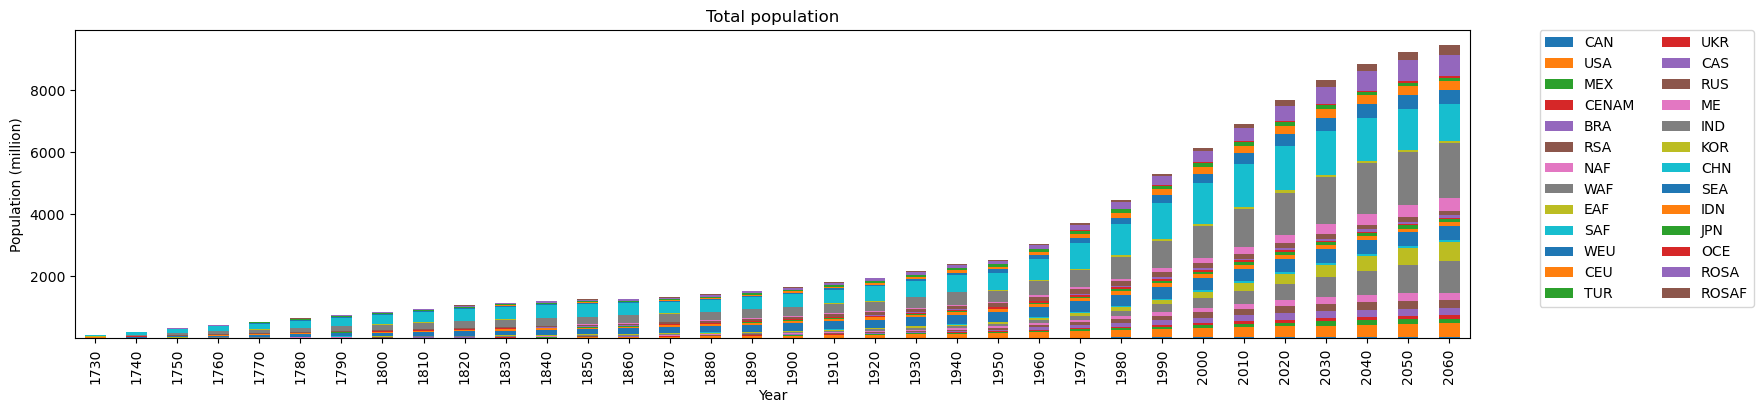

In [6]:
plot_tools.plot_database(pop_tail, 'Total population', 'Population (million)')

## Visualize the Building Per Capital Floorspace

In [7]:
commercial_m2_cap = commercial_m2_cap_office_tail+commercial_m2_cap_retail_tail+commercial_m2_cap_hotels_tail+commercial_m2_cap_govern_tail
# plot_tools.plot_database(floorspace_urb_tail, 'Urban Per Capita Floorspace', 'Urban Per Capita Floorspace (m2/cap)')
# plot_tools.plot_database(floorspace_rur_tail, 'Rural Per Capita Floorspace', 'Rural Per Capita Floorspace (m2/cap)')
# plot_tools.plot_database(commercial_m2_cap, 'Commercial Per Capita Floorspace', 'Commercial Per Capita Floorspace (m2/cap)')

# FLOOR AREA STOCK

In [8]:
#%% FLOOR AREA STOCK -----------------------------------------------------------

# adjust the share for urban/rural only (shares in csv are as percantage of the total(Rur + Urb), we needed to adjust the urban shares to add up to 1, same for rural)
housing_type_rur3 = housing_type_rur2/housing_type_rur2.sum()
housing_type_urb3 = housing_type_urb2/housing_type_urb2.sum()

# calculte the total rural/urban population (pop2 = millions of people, rurpop2 = % of people living in rural areas)
people_rur = pd.DataFrame(rurpop_tail.values*pop_tail.values, columns = pop_tail.columns, index = pop_tail.index)
people_urb = pd.DataFrame(urbpop_tail.values*pop_tail.values, columns = pop_tail.columns, index = pop_tail.index)

# calculate the total number of people (urban/rural) BY HOUSING TYPE (the sum of det,sem,app & hig equals the total population e.g. people_rur)
people_det_rur = pd.DataFrame(housing_type_rur3.iloc[0].values*people_rur.values, columns = people_rur.columns, index = people_rur.index)
people_sem_rur = pd.DataFrame(housing_type_rur3.iloc[1].values*people_rur.values, columns = people_rur.columns, index = people_rur.index)
people_app_rur = pd.DataFrame(housing_type_rur3.iloc[2].values*people_rur.values, columns = people_rur.columns, index = people_rur.index)
people_hig_rur = pd.DataFrame(housing_type_rur3.iloc[3].values*people_rur.values, columns = people_rur.columns, index = people_rur.index)

people_det_urb = pd.DataFrame(housing_type_urb3.iloc[0].values*people_urb.values, columns = people_urb.columns, index = people_urb.index)
people_sem_urb = pd.DataFrame(housing_type_urb3.iloc[1].values*people_urb.values, columns = people_urb.columns, index = people_urb.index)
people_app_urb = pd.DataFrame(housing_type_urb3.iloc[2].values*people_urb.values, columns = people_urb.columns, index = people_urb.index)
people_hig_urb = pd.DataFrame(housing_type_urb3.iloc[3].values*people_urb.values, columns = people_urb.columns, index = people_urb.index)

# calculate the total m2 (urban/rural) BY HOUSING TYPE (= nr. of people * OWN avg m2, so not based on IMAGE)
m2_unadjusted_det_rur = pd.DataFrame(avg_m2_cap_rur2.iloc[0].values * people_det_rur.values, columns = people_det_rur.columns, index = people_det_rur.index)
m2_unadjusted_sem_rur = pd.DataFrame(avg_m2_cap_rur2.iloc[1].values * people_sem_rur.values, columns = people_sem_rur.columns, index = people_sem_rur.index)
m2_unadjusted_app_rur = pd.DataFrame(avg_m2_cap_rur2.iloc[2].values * people_app_rur.values, columns = people_app_rur.columns, index = people_app_rur.index)
m2_unadjusted_hig_rur = pd.DataFrame(avg_m2_cap_rur2.iloc[3].values * people_hig_rur.values, columns = people_hig_rur.columns, index = people_hig_rur.index)

m2_unadjusted_det_urb = pd.DataFrame(avg_m2_cap_urb2.iloc[0].values * people_det_urb.values, columns = people_det_urb.columns, index = people_det_urb.index)
m2_unadjusted_sem_urb = pd.DataFrame(avg_m2_cap_urb2.iloc[1].values * people_sem_urb.values, columns = people_sem_urb.columns, index = people_sem_urb.index)
m2_unadjusted_app_urb = pd.DataFrame(avg_m2_cap_urb2.iloc[2].values * people_app_urb.values, columns = people_app_urb.columns, index = people_app_urb.index)
m2_unadjusted_hig_urb = pd.DataFrame(avg_m2_cap_urb2.iloc[3].values * people_hig_urb.values, columns = people_hig_urb.columns, index = people_hig_urb.index)

# Define empty dataframes for m2 adjustments
total_m2_adj_rur = pd.DataFrame(index = m2_unadjusted_det_rur.index, columns = m2_unadjusted_det_rur.columns)
total_m2_adj_urb = pd.DataFrame(index = m2_unadjusted_det_urb.index, columns = m2_unadjusted_det_urb.columns)

# Sum all square meters in Rural area
for j in range(1721,2061,1):
    for i in range(1,27,1):
        total_m2_adj_rur.loc[j,str(i)] = m2_unadjusted_det_rur.loc[j,str(i)] + m2_unadjusted_sem_rur.loc[j,str(i)] + m2_unadjusted_app_rur.loc[j,str(i)] + m2_unadjusted_hig_rur.loc[j,str(i)]

# Sum all square meters in Urban area
for j in range(1721,2061,1):
    for i in range(1,27,1):
        total_m2_adj_urb.loc[j,str(i)] = m2_unadjusted_det_urb.loc[j,str(i)] + m2_unadjusted_sem_urb.loc[j,str(i)] + m2_unadjusted_app_urb.loc[j,str(i)] + m2_unadjusted_hig_urb.loc[j,str(i)]

# average square meter per person implied by our OWN data
avg_m2_cap_adj_rur = pd.DataFrame(total_m2_adj_rur.values / people_rur.values, columns = people_rur.columns, index = people_rur.index) 
avg_m2_cap_adj_urb = pd.DataFrame(total_m2_adj_urb.values / people_urb.values, columns = people_urb.columns, index = people_urb.index)

# factor to correct square meters per capita so that we respect the IMAGE data in terms of total m2, but we use our own distinction between Building types
m2_cap_adj_fact_rur = pd.DataFrame(floorspace_rur_tail.values / avg_m2_cap_adj_rur.values, columns = floorspace_rur_tail.columns, index = floorspace_rur_tail.index)
m2_cap_adj_fact_urb = pd.DataFrame(floorspace_urb_tail.values / avg_m2_cap_adj_urb.values, columns = floorspace_urb_tail.columns, index = floorspace_urb_tail.index)

# All m2 by region (in millions), Building_type & year (using the correction factor, to comply with IMAGE avg m2/cap)
m2_det_rur = pd.DataFrame(m2_unadjusted_det_rur.values * m2_cap_adj_fact_rur.values, columns = m2_cap_adj_fact_rur.columns, index = m2_cap_adj_fact_rur.index)
m2_sem_rur = pd.DataFrame(m2_unadjusted_sem_rur.values * m2_cap_adj_fact_rur.values, columns = m2_cap_adj_fact_rur.columns, index = m2_cap_adj_fact_rur.index)
m2_app_rur = pd.DataFrame(m2_unadjusted_app_rur.values * m2_cap_adj_fact_rur.values, columns = m2_cap_adj_fact_rur.columns, index = m2_cap_adj_fact_rur.index)
m2_hig_rur = pd.DataFrame(m2_unadjusted_hig_rur.values * m2_cap_adj_fact_rur.values, columns = m2_cap_adj_fact_rur.columns, index = m2_cap_adj_fact_rur.index)

m2_det_urb = pd.DataFrame(m2_unadjusted_det_urb.values * m2_cap_adj_fact_urb.values, columns = m2_cap_adj_fact_urb.columns, index = m2_cap_adj_fact_urb.index)
m2_sem_urb = pd.DataFrame(m2_unadjusted_sem_urb.values * m2_cap_adj_fact_urb.values, columns = m2_cap_adj_fact_urb.columns, index = m2_cap_adj_fact_urb.index)
m2_app_urb = pd.DataFrame(m2_unadjusted_app_urb.values * m2_cap_adj_fact_urb.values, columns = m2_cap_adj_fact_urb.columns, index = m2_cap_adj_fact_urb.index)
m2_hig_urb = pd.DataFrame(m2_unadjusted_hig_urb.values * m2_cap_adj_fact_urb.values, columns = m2_cap_adj_fact_urb.columns, index = m2_cap_adj_fact_urb.index)

# Add a checksum to see if calculations based on adjusted OWN avg m2 (by building type) now match the total m2 according to IMAGE. 
m2_sum_rur_OWN = m2_det_rur + m2_sem_rur + m2_app_rur + m2_hig_rur
m2_sum_rur_IMAGE = pd.DataFrame(floorspace_rur_tail.values*people_rur.values, columns = m2_sum_rur_OWN.columns, index = m2_sum_rur_OWN.index)
m2_checksum = m2_sum_rur_OWN - m2_sum_rur_IMAGE
if m2_checksum.sum().sum() > 0.0000001 or m2_checksum.sum().sum() < -0.0000001:
    ctypes.windll.user32.MessageBoxW(0, "IMAGE & OWN m2 sums do not match", "Warning", 1)

# Total RESIDENTIAL square meters by region
m2 = m2_det_rur + m2_sem_rur + m2_app_rur + m2_hig_rur + m2_det_urb + m2_sem_urb + m2_app_urb + m2_hig_urb

# Total m2 for COMMERCIAL Buildings
commercial_m2_office = pd.DataFrame(commercial_m2_cap_office_tail.values * pop_tail.values, columns = m2_cap_adj_fact_urb.columns, index = m2_cap_adj_fact_urb.index)
commercial_m2_retail = pd.DataFrame(commercial_m2_cap_retail_tail.values * pop_tail.values, columns = m2_cap_adj_fact_urb.columns, index = m2_cap_adj_fact_urb.index)
commercial_m2_hotels = pd.DataFrame(commercial_m2_cap_hotels_tail.values * pop_tail.values, columns = m2_cap_adj_fact_urb.columns, index = m2_cap_adj_fact_urb.index)
commercial_m2_govern = pd.DataFrame(commercial_m2_cap_govern_tail.values * pop_tail.values, columns = m2_cap_adj_fact_urb.columns, index = m2_cap_adj_fact_urb.index)

## Visualize the Building Floorspace Stock

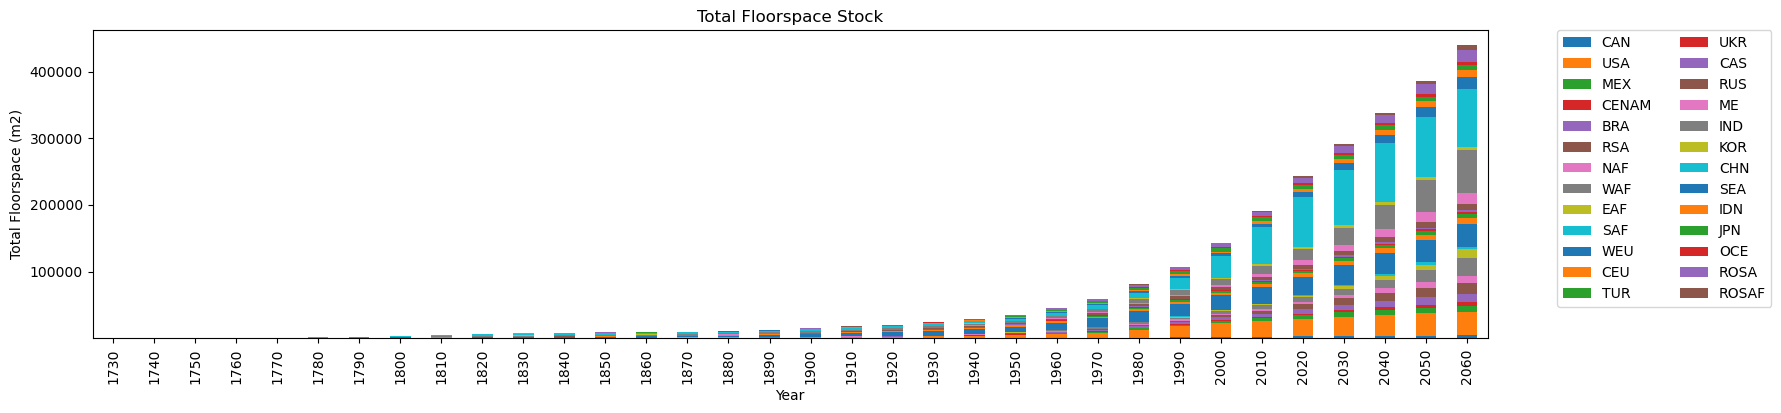

In [9]:
m2_rur = m2_det_rur + m2_sem_rur + m2_app_rur + m2_hig_rur
m2_urb = m2_det_urb + m2_sem_urb + m2_app_urb + m2_hig_urb
m2_com = commercial_m2_office + commercial_m2_retail + commercial_m2_hotels + commercial_m2_govern

m2_sum = m2_rur + m2_urb + m2_com

plot_tools.plot_database(m2_sum, 'Total Floorspace Stock', 'Total Floorspace (m2)')
# plot_tools.plot_database(m2_rur, 'Rural Floorspace Stock', 'Rural Floorspace (m2)')
# plot_tools.plot_database(m2_urb, 'Urban Floorspace Stock', 'Urban Floorspace (m2)')
# plot_tools.plot_database(m2_com, 'Commercial Floorspace Stock', 'Commercial Floorspace (m2)')

# FLOOR AREA INFLOW & OUTFLOW

In [10]:
#%% FLOOR AREA INFLOW & OUTFLOW

import sys 
sys.path.append(dir_path)
import dynamic_stock_model
from dynamic_stock_model import DynamicStockModel as DSM
idx = pd.IndexSlice   # needed for slicing multi-index

# define a function for calculating the floor area inflow and outflow
def inflow_outflown(shape, scale, stock, length):            # length is the number of years in the entire period
    out_oc_reg = pd.DataFrame(index = range(1721,2061), columns =  pd.MultiIndex.from_product([list(range(1,27)), list(range(1721,2061))]))  # Multi-index columns (region & years), to contain a matrix of years*years for each region
    out_i_reg = pd.DataFrame(index = range(1721,2061), columns = range(1,27))
    out_s_reg = pd.DataFrame(index = range(1721,2061), columns = range(1,27))
    out_o_reg = pd.DataFrame(index = range(1721,2061), columns = range(1,27))
    
    for region in range(1,27):
        shape_list = shape.loc[region]
        scale_list = scale.loc[region]
        
        if flag_Normal == 0:
            DSMforward = DSM(t = np.arange(0,length,1), s =  np.array(stock[region]), lt = {'Type': 'Weibull', 'Shape': np.array(shape_list), 'Scale': np.array(scale_list)})
        else:
            DSMforward = DSM(t = np.arange(0,length,1), s =  np.array(stock[region]), lt = {'Type': 'FoldNorm', 'Mean': np.array(shape_list), 'StdDev': np.array(scale_list)}) # shape & scale list are actually Mean & StDev here
        
        out_sc, out_oc, out_i = DSMforward.compute_stock_driven_model(NegativeInflowCorrect = True)
        
        out_i_reg[region] = out_i        
        out_oc[out_oc < 0] = 0 # remove negative outflow, replace by 0
        out_oc_reg.loc[:,idx[region,:]]  = out_oc
        
        # If you are only interested in the total outflow, you can sum the outflow by cohort
        out_o_reg[region] = out_oc.sum(axis = 1)
        out_o_reg_corr = out_o_reg._get_numeric_data()        
        out_o_reg_corr[out_o_reg_corr < 0] = 0            
        out_s_reg[region] = out_sc.sum(axis = 1) #Stock 
        
    return out_i_reg, out_oc_reg

length = len(m2_hig_urb[1])  # = 340
#nindex = np.arange(0,26)

#% lifetime parameters (shape & scale)
lifetimes = pd.read_csv(dir_path + '/files_lifetimes/lifetimes.csv')
lifetimes_comm = pd.read_csv(dir_path + '/files_lifetimes/lifetimes_comm.csv')

# separate shape from scale
lifetimes_shape = lifetimes[['Region','Building_type','Area','Shape']]
lifetimes_scale = lifetimes[['Region','Building_type','Area','Scale']]
shape_comm = lifetimes_comm[['Region','Shape']]
scale_comm = lifetimes_comm[['Region','Scale']]

# generate time-series data structure
for i in range(1721,2061):
    lifetimes_shape[i] = lifetimes_shape['Shape']
    lifetimes_scale[i] = lifetimes_scale['Scale']
    shape_comm[i] = shape_comm['Shape']
    scale_comm[i] = scale_comm['Scale']

# parameters by building type    
lifetimes_shape = lifetimes_shape.drop(['Shape'],axis = 1)
lifetimes_scale = lifetimes_scale.drop(['Scale'],axis = 1)
shape_comm = shape_comm.drop(['Shape'],axis = 1).set_index('Region')
scale_comm = scale_comm.drop(['Scale'],axis = 1).set_index('Region')

shape_det_rur = lifetimes_shape.loc[(lifetimes_shape['Area'] == 'Rural') & (lifetimes_shape['Building_type'] == 'Detached')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
shape_sem_rur = lifetimes_shape.loc[(lifetimes_shape['Area'] == 'Rural') & (lifetimes_shape['Building_type'] == 'Semi-detached')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
shape_app_rur = lifetimes_shape.loc[(lifetimes_shape['Area'] == 'Rural') & (lifetimes_shape['Building_type'] == 'Appartments')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
shape_hig_rur = lifetimes_shape.loc[(lifetimes_shape['Area'] == 'Rural') & (lifetimes_shape['Building_type'] == 'High-rise')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)

shape_det_urb = lifetimes_shape.loc[(lifetimes_shape['Area'] == 'Urban') & (lifetimes_shape['Building_type'] == 'Detached')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
shape_sem_urb = lifetimes_shape.loc[(lifetimes_shape['Area'] == 'Urban') & (lifetimes_shape['Building_type'] == 'Semi-detached')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
shape_app_urb = lifetimes_shape.loc[(lifetimes_shape['Area'] == 'Urban') & (lifetimes_shape['Building_type'] == 'Appartments')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
shape_hig_urb = lifetimes_shape.loc[(lifetimes_shape['Area'] == 'Urban') & (lifetimes_shape['Building_type'] == 'High-rise')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)

scale_det_rur = lifetimes_scale.loc[(lifetimes_scale['Area'] == 'Rural') & (lifetimes_scale['Building_type'] == 'Detached')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
scale_sem_rur = lifetimes_scale.loc[(lifetimes_scale['Area'] == 'Rural') & (lifetimes_scale['Building_type'] == 'Semi-detached')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
scale_app_rur = lifetimes_scale.loc[(lifetimes_scale['Area'] == 'Rural') & (lifetimes_scale['Building_type'] == 'Appartments')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
scale_hig_rur = lifetimes_scale.loc[(lifetimes_scale['Area'] == 'Rural') & (lifetimes_scale['Building_type'] == 'High-rise')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)

scale_det_urb = lifetimes_scale.loc[(lifetimes_scale['Area'] == 'Urban') & (lifetimes_scale['Building_type'] == 'Detached')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
scale_sem_urb = lifetimes_scale.loc[(lifetimes_scale['Area'] == 'Urban') & (lifetimes_scale['Building_type'] == 'Semi-detached')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
scale_app_urb = lifetimes_scale.loc[(lifetimes_scale['Area'] == 'Urban') & (lifetimes_scale['Building_type'] == 'Appartments')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)
scale_hig_urb = lifetimes_scale.loc[(lifetimes_scale['Area'] == 'Urban') & (lifetimes_scale['Building_type'] == 'High-rise')].set_index('Region').drop(['Building_type', 'Area'],axis = 1)

# call the defined model to calculate inflow & outflow based on stock & lifetime
m2_det_rur_i, m2_det_rur_oc = inflow_outflown(shape_det_rur, scale_det_rur, m2_det_rur, length)
m2_sem_rur_i, m2_sem_rur_oc = inflow_outflown(shape_sem_rur, scale_sem_rur, m2_sem_rur, length)
m2_app_rur_i, m2_app_rur_oc = inflow_outflown(shape_app_rur, scale_app_rur, m2_app_rur, length)
m2_hig_rur_i, m2_hig_rur_oc = inflow_outflown(shape_hig_rur, scale_hig_rur, m2_hig_rur, length)

m2_det_urb_i, m2_det_urb_oc = inflow_outflown(shape_det_urb, scale_det_urb, m2_det_urb, length)
m2_sem_urb_i, m2_sem_urb_oc = inflow_outflown(shape_sem_urb, scale_sem_urb, m2_sem_urb, length)
m2_app_urb_i, m2_app_urb_oc = inflow_outflown(shape_app_urb, scale_app_urb, m2_app_urb, length)
m2_hig_urb_i, m2_hig_urb_oc = inflow_outflown(shape_hig_urb, scale_hig_urb, m2_hig_urb, length)

m2_office_i, m2_office_oc = inflow_outflown(shape_comm, scale_comm, commercial_m2_office, length)
m2_retail_i, m2_retail_oc = inflow_outflown(shape_comm, scale_comm, commercial_m2_retail, length)
m2_hotels_i, m2_hotels_oc = inflow_outflown(shape_comm, scale_comm, commercial_m2_hotels, length)
m2_govern_i, m2_govern_oc = inflow_outflown(shape_comm, scale_comm, commercial_m2_govern, length)

# total MILLIONS of square meters inflow
m2_res_i = m2_det_rur_i + m2_sem_rur_i + m2_app_rur_i + m2_hig_rur_i + m2_det_urb_i + m2_sem_urb_i + m2_app_urb_i + m2_hig_urb_i
m2_comm_i = m2_office_i + m2_retail_i + m2_hotels_i + m2_govern_i

c:\ProgramData\Anaconda3\envs\environment\lib\site-packages\ipykernel_launcher.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
c:\ProgramData\Anaconda3\envs\environment\lib\site-packages\ipykernel_launcher.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
c:\ProgramData\Anaconda3\envs\environment\lib\site-packages\ipykernel_launcher.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

## Visualize the Building Floorspace Inflow

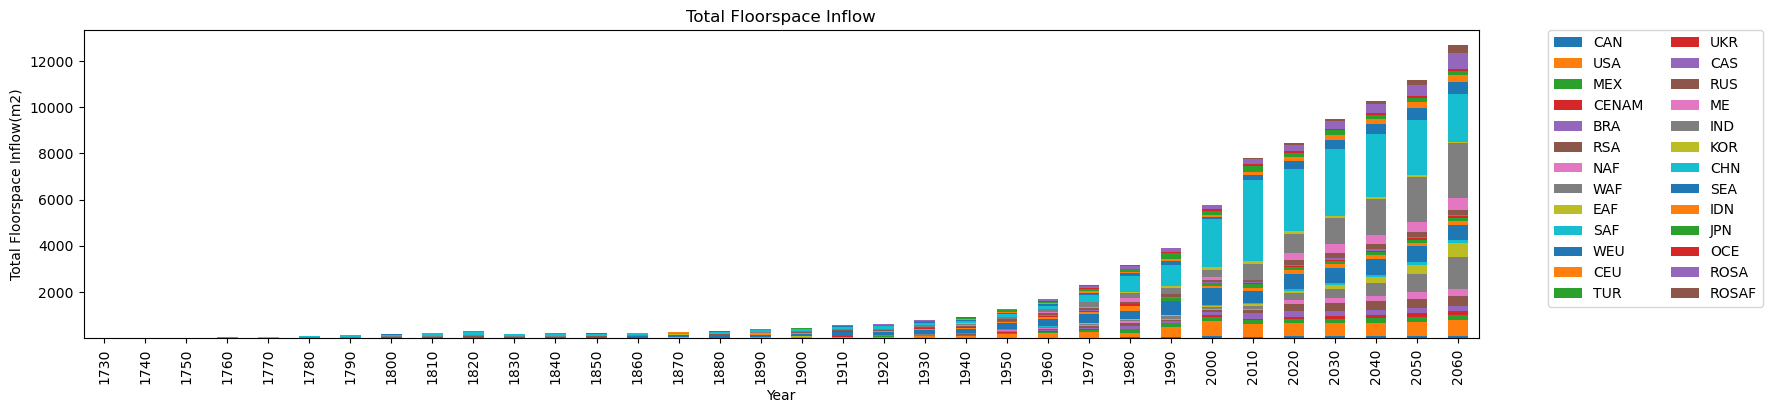

In [11]:
m2_i = m2_res_i + m2_comm_i

plot_tools.plot_database(m2_i, 'Total Floorspace Inflow', 'Total Floorspace Inflow(m2)')
# plot_tools.plot_database(m2_res_i, 'Residential Floorspace Inflow', 'Residential Floorspace Inflow(m2)')
# plot_tools.plot_database(m2_comm_i, 'Commercial Floorspace Inflow', 'Commercial Floorspace Inflow(m2)')

# MATERIAL INTENSITY

In [12]:
#%% MATERIAL INTENSITY RESTRUCTURING (to become consistent with floor area dataset)-----------------------------------------------------------
# separate different materials
building_materials_concrete = building_materials[['Region','Building_type','concrete']]
building_materials_glass = building_materials[['Region','Building_type','glass']]

materials_commercial_concrete = materials_commercial[['Region','Building_type','concrete']]
materials_commercial_glass = materials_commercial[['Region','Building_type','glass']]

# generate time-series data structure
for i in range(1721,2061):
    building_materials_concrete[i] = building_materials_concrete['concrete']
    building_materials_glass[i] = building_materials_glass['glass']
    materials_commercial_concrete[i] = materials_commercial_concrete['concrete']
    materials_commercial_glass[i] = materials_commercial_glass['glass']

building_materials_concrete = building_materials_concrete.drop(['concrete'],axis = 1)
building_materials_glass = building_materials_glass.drop(['glass'],axis = 1)

materials_commercial_concrete = materials_commercial_concrete.drop(['concrete'],axis = 1)
materials_commercial_glass = materials_commercial_glass.drop(['glass'],axis = 1)

# concrete intensity
material_concrete_det = building_materials_concrete.loc[(building_materials_concrete['Building_type']=='Detached')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(m2_det_rur.index)
material_concrete_sem = building_materials_concrete.loc[(building_materials_concrete['Building_type']=='Semi-detached')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(m2_sem_rur.index)
material_concrete_app = building_materials_concrete.loc[(building_materials_concrete['Building_type']=='Appartments')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(m2_app_rur.index)
material_concrete_hig = building_materials_concrete.loc[(building_materials_concrete['Building_type']=='High-rise')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(m2_hig_rur.index)

materials_concrete_office = materials_commercial_concrete.loc[(materials_commercial_concrete['Building_type']=='Offices')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(commercial_m2_office.index)
materials_concrete_retail = materials_commercial_concrete.loc[(materials_commercial_concrete['Building_type']=='Retail+')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(commercial_m2_retail.index)
materials_concrete_hotels = materials_commercial_concrete.loc[(materials_commercial_concrete['Building_type']=='Hotels+')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(commercial_m2_hotels.index)
materials_concrete_govern = materials_commercial_concrete.loc[(materials_commercial_concrete['Building_type']=='Govt+')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(commercial_m2_govern.index)

# glass intensity
material_glass_det = building_materials_glass.loc[(building_materials_glass['Building_type']=='Detached')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(m2_det_rur.index)
material_glass_sem = building_materials_glass.loc[(building_materials_glass['Building_type']=='Semi-detached')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(m2_sem_rur.index)
material_glass_app = building_materials_glass.loc[(building_materials_glass['Building_type']=='Appartments')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(m2_app_rur.index)
material_glass_hig = building_materials_glass.loc[(building_materials_glass['Building_type']=='High-rise')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(m2_hig_rur.index)

materials_glass_office = materials_commercial_glass.loc[(materials_commercial_glass['Building_type']=='Offices')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(commercial_m2_office.index)
materials_glass_retail = materials_commercial_glass.loc[(materials_commercial_glass['Building_type']=='Retail+')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(commercial_m2_retail.index)
materials_glass_hotels = materials_commercial_glass.loc[(materials_commercial_glass['Building_type']=='Hotels+')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(commercial_m2_hotels.index)
materials_glass_govern = materials_commercial_glass.loc[(materials_commercial_glass['Building_type']=='Govt+')].set_index('Region').drop(['Building_type'],axis = 1).T.set_index(commercial_m2_govern.index)



c:\ProgramData\Anaconda3\envs\environment\lib\site-packages\ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()
c:\ProgramData\Anaconda3\envs\environment\lib\site-packages\ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if sys.path[0] == "":
c:\ProgramData\Anaconda3\envs\environment\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

In [13]:
#%% Material inflow & outflow
#% Material inflow (Millions of kgs = *1000 tons)
# concrete
kg_det_rur_concrete_i = m2_det_rur_i * material_concrete_det
kg_sem_rur_concrete_i = m2_sem_rur_i * material_concrete_sem
kg_app_rur_concrete_i = m2_app_rur_i * material_concrete_app
kg_hig_rur_concrete_i = m2_hig_rur_i * material_concrete_hig

kg_det_urb_concrete_i = m2_det_urb_i * material_concrete_det
kg_sem_urb_concrete_i = m2_sem_urb_i * material_concrete_sem
kg_app_urb_concrete_i = m2_app_urb_i * material_concrete_app
kg_hig_urb_concrete_i = m2_hig_urb_i * material_concrete_hig

kg_office_concrete_i = m2_office_i * materials_concrete_office
kg_retail_concrete_i = m2_retail_i * materials_concrete_retail
kg_hotels_concrete_i = m2_hotels_i * materials_concrete_hotels
kg_govern_concrete_i = m2_govern_i * materials_concrete_govern

# glass
kg_det_rur_glass_i = m2_det_rur_i * material_glass_det
kg_sem_rur_glass_i = m2_sem_rur_i * material_glass_sem
kg_app_rur_glass_i = m2_app_rur_i * material_glass_app
kg_hig_rur_glass_i = m2_hig_rur_i * material_glass_hig

kg_det_urb_glass_i = m2_det_urb_i * material_glass_det
kg_sem_urb_glass_i = m2_sem_urb_i * material_glass_sem
kg_app_urb_glass_i = m2_app_urb_i * material_glass_app
kg_hig_urb_glass_i = m2_hig_urb_i * material_glass_hig

kg_office_glass_i = m2_office_i * materials_glass_office
kg_retail_glass_i = m2_retail_i * materials_glass_retail
kg_hotels_glass_i = m2_hotels_i * materials_glass_hotels
kg_govern_glass_i = m2_govern_i * materials_glass_govern



## Visualize the Material Inflow

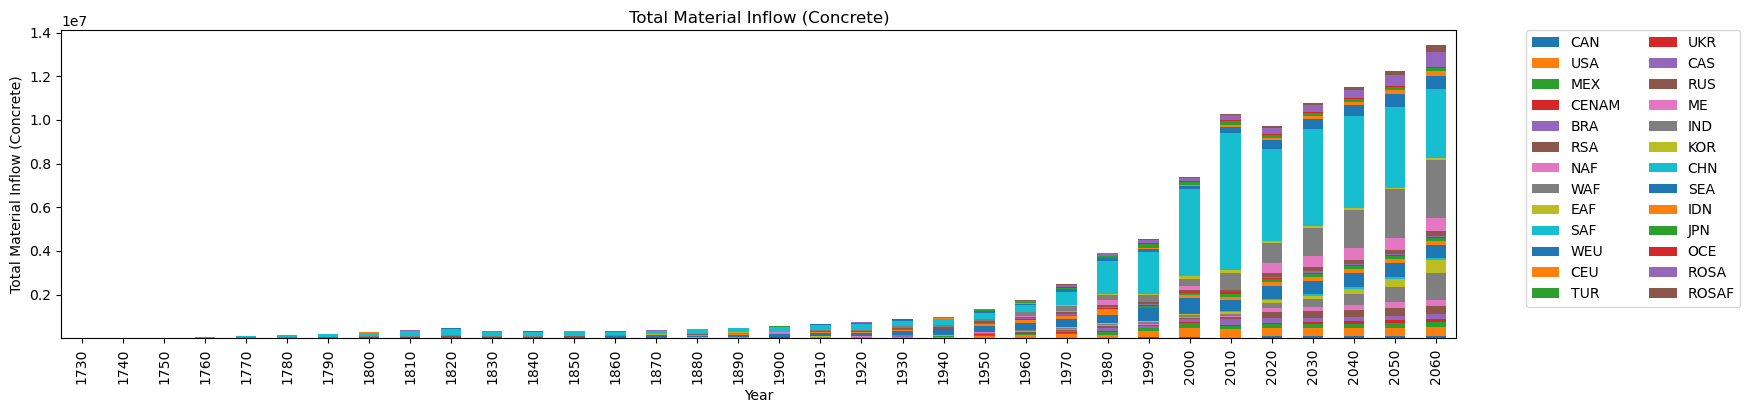

In [14]:
kg_rur_i = kg_det_rur_concrete_i + kg_sem_rur_concrete_i + kg_app_rur_concrete_i + kg_hig_rur_concrete_i
kg_urb_i = kg_det_urb_concrete_i + kg_sem_urb_concrete_i + kg_app_urb_concrete_i + kg_hig_urb_concrete_i
kg_com_i = kg_office_concrete_i + kg_retail_concrete_i + kg_hotels_concrete_i + kg_govern_concrete_i
kg_i = kg_rur_i + kg_urb_i + kg_com_i

plot_tools.plot_database(kg_i, 'Total Material Inflow (Concrete)', 'Total Material Inflow (Concrete)')
# plot_tools.plot_database(kg_rur_i, 'Rural Material Inflow (Concrete)', 'Rural Material Inflow (Concrete)')
# plot_tools.plot_database(kg_urb_i, 'Urban Material Inflow (Concrete)', 'Urban Material Inflow (Concrete)')
# plot_tools.plot_database(kg_com_i, 'Commercial Material Inflow (Concrete)', 'Commercial Material Inflow (Concrete)')

In [15]:
#% Material outflow (Millions of kgs = *1000 tons)
# first define a function for calculating the material outflow by cohort
def material_outflow(m2_outflow_cohort,material_density):
    emp = []
    for i in range(0,26):
        md = material_density.iloc[:,i]
        m2 = m2_outflow_cohort.loc[:,(i+1,1721):(i+1,2060)]
        m2.columns = md.index
        material_outflow_cohort =  m2*md
        material_outflow_cohort_sum = material_outflow_cohort.sum(1)
        emp.append(material_outflow_cohort_sum)
    result = pd.DataFrame(emp)
    result.index = range(1, 27)
    return result.T

# concrete outflow
kg_det_rur_concrete_o = material_outflow(m2_det_rur_oc,material_concrete_det)
kg_sem_rur_concrete_o = material_outflow(m2_sem_rur_oc, material_concrete_sem)
kg_app_rur_concrete_o = material_outflow(m2_app_rur_oc, material_concrete_app)
kg_hig_rur_concrete_o = material_outflow(m2_hig_rur_oc, material_concrete_hig)

kg_det_urb_concrete_o = material_outflow(m2_det_urb_oc, material_concrete_det)
kg_sem_urb_concrete_o = material_outflow(m2_sem_urb_oc, material_concrete_sem)
kg_app_urb_concrete_o = material_outflow(m2_app_urb_oc, material_concrete_app)
kg_hig_urb_concrete_o = material_outflow(m2_hig_urb_oc, material_concrete_hig)

kg_office_concrete_o = material_outflow(m2_office_oc, materials_concrete_office)
kg_retail_concrete_o = material_outflow(m2_retail_oc, materials_concrete_retail)
kg_hotels_concrete_o = material_outflow(m2_hotels_oc, materials_concrete_hotels)
kg_govern_concrete_o = material_outflow(m2_govern_oc, materials_concrete_govern)

# glass outflow
kg_det_rur_glass_o = material_outflow(m2_det_rur_oc, material_glass_det)
kg_sem_rur_glass_o = material_outflow(m2_sem_rur_oc, material_glass_sem)
kg_app_rur_glass_o = material_outflow(m2_app_rur_oc, material_glass_app)
kg_hig_rur_glass_o = material_outflow(m2_hig_rur_oc, material_glass_hig)

kg_det_urb_glass_o = material_outflow(m2_det_urb_oc, material_glass_det)
kg_sem_urb_glass_o = material_outflow(m2_sem_urb_oc, material_glass_sem)
kg_app_urb_glass_o = material_outflow(m2_app_urb_oc, material_glass_app)
kg_hig_urb_glass_o = material_outflow(m2_hig_urb_oc, material_glass_hig)

kg_office_glass_o = material_outflow(m2_office_oc, materials_glass_office)
kg_retail_glass_o = material_outflow(m2_retail_oc, materials_glass_retail)
kg_hotels_glass_o = material_outflow(m2_hotels_oc, materials_glass_hotels)
kg_govern_glass_o = material_outflow(m2_govern_oc, materials_glass_govern)

## Visualize the Material Outflow

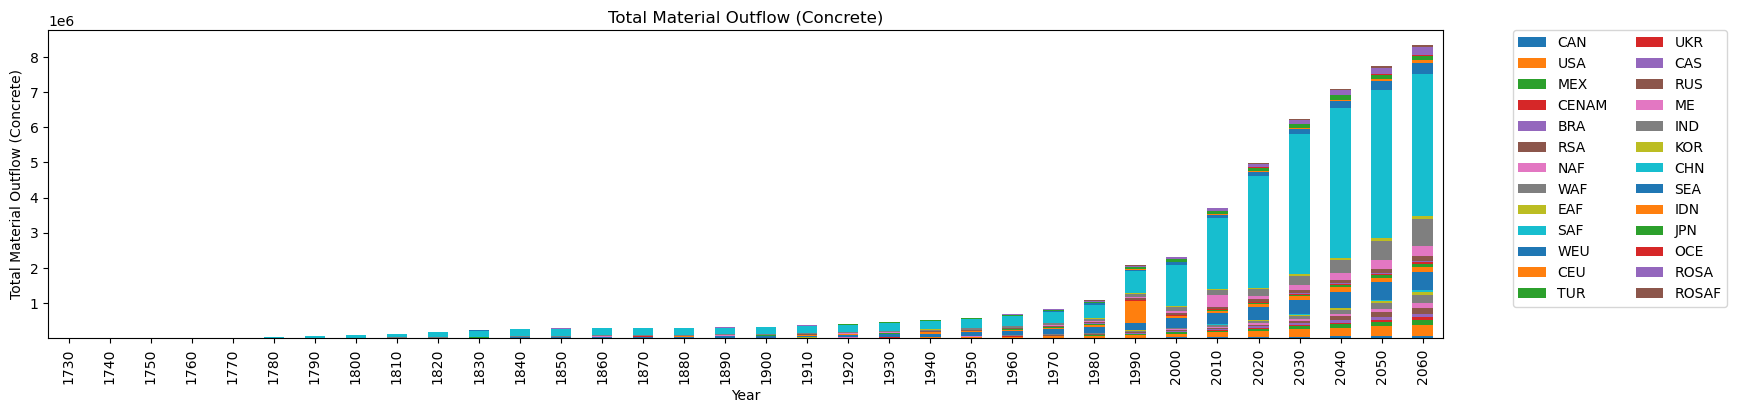

In [16]:
kg_rur_o = kg_det_rur_concrete_o + kg_sem_rur_concrete_o + kg_app_rur_concrete_o + kg_hig_rur_concrete_o
kg_urb_o = kg_det_urb_concrete_o + kg_sem_urb_concrete_o + kg_app_urb_concrete_o + kg_hig_urb_concrete_o
kg_com_o = kg_office_concrete_o + kg_retail_concrete_o + kg_hotels_concrete_o + kg_govern_concrete_o
kg_o = kg_rur_o + kg_urb_o + kg_com_o

plot_tools.plot_database(kg_o, 'Total Material Outflow (Concrete)', 'Total Material Outflow (Concrete)')
# plot_tools.plot_database(kg_rur_o, 'Rural Material Outflow (Concrete)', 'Rural Material Outflow (Concrete)')
# plot_tools.plot_database(kg_urb_o, 'Urban Material Outflow (Concrete)', 'Urban Material Outflow (Concrete)')
# plot_tools.plot_database(kg_com_o, 'Commercial Material Outflow (Concrete)', 'Commercial Material Outflow (Concrete)')

# Pre-process Output (material inflow & outflow)

In [17]:
# first, define a function to transpose + combine all variables & add columns to identify material, area & appartment type. Only for csv output
length = 2
tag = ['inflow', 'outflow']

def preprocess(inflow, outflow, area, building, material):
   output_combined = [[]] * length
   output_combined[0] = inflow.transpose()
   output_combined[1] = outflow.transpose()
   for item in range(0,length):
      output_combined[item].insert(0,'material', [material] * 26)
      output_combined[item].insert(0,'area', [area] * 26)
      output_combined[item].insert(0,'type', [building] * 26)
      output_combined[item].insert(0,'flow', [tag[item]] * 26)
   return output_combined

# concrete output
kg_det_rur_concrete_out  = preprocess(kg_det_rur_concrete_i,  kg_det_rur_concrete_o,  'rural','detached', 'concrete') 
kg_sem_rur_concrete_out  = preprocess(kg_sem_rur_concrete_i,  kg_sem_rur_concrete_o,  'rural','semi-detached', 'concrete') 
kg_app_rur_concrete_out  = preprocess(kg_app_rur_concrete_i,  kg_app_rur_concrete_o,  'rural','appartments', 'concrete') 
kg_hig_rur_concrete_out  = preprocess(kg_hig_rur_concrete_i,  kg_hig_rur_concrete_o,  'rural','high-rise', 'concrete') 

kg_det_urb_concrete_out  = preprocess(kg_det_urb_concrete_i,  kg_det_urb_concrete_o,  'urban','detached', 'concrete') 
kg_sem_urb_concrete_out  = preprocess(kg_sem_urb_concrete_i,  kg_sem_urb_concrete_o,  'urban','semi-detached', 'concrete') 
kg_app_urb_concrete_out  = preprocess(kg_app_urb_concrete_i,  kg_app_urb_concrete_o,  'urban','appartments', 'concrete') 
kg_hig_urb_concrete_out  = preprocess(kg_hig_urb_concrete_i,  kg_hig_urb_concrete_o,  'urban','high-rise', 'concrete') 

kg_office_concrete_out  = preprocess(kg_office_concrete_i,  kg_office_concrete_o,  'commercial','office', 'concrete')
kg_retail_concrete_out  = preprocess(kg_retail_concrete_i,  kg_retail_concrete_o,  'commercial','retail', 'concrete')
kg_hotels_concrete_out  = preprocess(kg_hotels_concrete_i,  kg_hotels_concrete_o,  'commercial','hotels', 'concrete')
kg_govern_concrete_out  = preprocess(kg_govern_concrete_i,  kg_govern_concrete_o,  'commercial','govern', 'concrete')

# glass output
kg_det_rur_glass_out     = preprocess(kg_det_rur_glass_i,     kg_det_rur_glass_o,     'rural','detached', 'glass')
kg_sem_rur_glass_out     = preprocess(kg_sem_rur_glass_i,     kg_sem_rur_glass_o,     'rural','semi-detached', 'glass')
kg_app_rur_glass_out     = preprocess(kg_app_rur_glass_i,     kg_app_rur_glass_o,     'rural','appartments', 'glass')
kg_hig_rur_glass_out     = preprocess(kg_hig_rur_glass_i,     kg_hig_rur_glass_o,     'rural','high-rise', 'glass')

kg_det_urb_glass_out     = preprocess(kg_det_urb_glass_i,     kg_det_urb_glass_o,     'urban','detached', 'glass')
kg_sem_urb_glass_out     = preprocess(kg_sem_urb_glass_i,     kg_sem_urb_glass_o,     'urban','semi-detached', 'glass')
kg_app_urb_glass_out     = preprocess(kg_app_urb_glass_i,     kg_app_urb_glass_o,     'urban','appartments', 'glass')
kg_hig_urb_glass_out     = preprocess(kg_hig_urb_glass_i,     kg_hig_urb_glass_o,     'urban','high-rise', 'glass')

kg_office_glass_out     = preprocess(kg_office_glass_i,     kg_office_glass_o,     'commercial','office', 'glass')
kg_retail_glass_out     = preprocess(kg_retail_glass_i,     kg_retail_glass_o,     'commercial','retail', 'glass')
kg_hotels_glass_out     = preprocess(kg_hotels_glass_i,     kg_hotels_glass_o,     'commercial','hotels', 'glass')
kg_govern_glass_out     = preprocess(kg_govern_glass_i,     kg_govern_glass_o,     'commercial','govern', 'glass')

# stack into 1 dataframe
frames =    [kg_det_rur_concrete_out[0], kg_det_rur_glass_out[0],    
             kg_sem_rur_concrete_out[0], kg_sem_rur_glass_out[0],    
             kg_app_rur_concrete_out[0], kg_app_rur_glass_out[0],    
             kg_hig_rur_concrete_out[0], kg_hig_rur_glass_out[0],    
             kg_det_urb_concrete_out[0], kg_det_urb_glass_out[0],    
             kg_sem_urb_concrete_out[0], kg_sem_urb_glass_out[0],    
             kg_app_urb_concrete_out[0], kg_app_urb_glass_out[0],    
             kg_hig_urb_concrete_out[0], kg_hig_urb_glass_out[0],
             kg_office_concrete_out[0],  kg_office_glass_out[0],
             kg_retail_concrete_out[0],  kg_retail_glass_out[0],
             kg_hotels_concrete_out[0],  kg_hotels_glass_out[0],
             kg_govern_concrete_out[0],  kg_govern_glass_out[0],
                                                           
             kg_det_rur_concrete_out[1], kg_det_rur_glass_out[1],    
             kg_sem_rur_concrete_out[1], kg_sem_rur_glass_out[1],    
             kg_app_rur_concrete_out[1], kg_app_rur_glass_out[1],    
             kg_hig_rur_concrete_out[1], kg_hig_rur_glass_out[1],    
             kg_det_urb_concrete_out[1], kg_det_urb_glass_out[1],    
             kg_sem_urb_concrete_out[1], kg_sem_urb_glass_out[1],    
             kg_app_urb_concrete_out[1], kg_app_urb_glass_out[1],    
             kg_hig_urb_concrete_out[1], kg_hig_urb_glass_out[1],
             kg_office_concrete_out[1],  kg_office_glass_out[1],
             kg_retail_concrete_out[1],  kg_retail_glass_out[1],
             kg_hotels_concrete_out[1],  kg_hotels_glass_out[1],
             kg_govern_concrete_out[1],  kg_govern_glass_out[1] ]

material_output = pd.concat(frames)
material_output.to_csv('output_material/concrete_glass_output.csv')

# %% sand in concrete and glass
# load material flows csv-file
building_materials = pd.read_csv('output_material/concrete_glass_output.csv')

building_materials_inflow = building_materials.loc[(building_materials['flow']=='inflow')].set_index('Unnamed: 0')
building_materials_outflow = building_materials.loc[(building_materials['flow']=='outflow')].set_index('Unnamed: 0')
index_material = building_materials_inflow[['flow','type','area','material']]

# Reuse and Recovery

In [18]:
# load recovery and reuse csv-files
recovery_rate = pd.read_csv('files_recovery_rate/recovery_rate.csv').set_index('Unnamed: 0')
reuse_rate = pd.read_csv('files_recovery_rate/reuse_rate.csv').set_index('Unnamed: 0')

# copy 1900 values to historic years
j = 4
for i in range(1721,1900):
    recovery_rate.insert(loc=j, column=i, value = recovery_rate['1900'])
    reuse_rate.insert(loc=j, column=i, value = reuse_rate['1900'])
    j = j + 1

# calculating available material recovery and reuse (recovery means total scrap collection)
building_materials_outflow = building_materials_outflow.iloc[:,4:]
recovery_rate = recovery_rate.iloc[:,4:]
reuse_rate = reuse_rate.iloc[:,4:]
recovery_rate.columns = building_materials_outflow.columns
reuse_rate.columns = building_materials_outflow.columns

materials_recovery_available = building_materials_outflow * recovery_rate
materials_reuse_available = building_materials_outflow * reuse_rate

# calculating primary and secondary materials
a = building_materials_inflow.iloc[:,4:].values
b = materials_recovery_available.values
c = materials_reuse_available.values

materials_recovery = pd.DataFrame(np.where(a < b, a, b), index = materials_recovery_available.index, columns = materials_recovery_available.columns)
materials_reuse = pd.DataFrame(np.where(a < c, a, c), index = materials_reuse_available.index, columns = materials_reuse_available.columns)
materials_primary = building_materials_inflow - materials_recovery
materials_secondary = materials_recovery - materials_reuse
materials_primary = building_materials_inflow.iloc[:,4:]-materials_recovery

# load sand intensity csv-files
sand_primary_per_kg = pd.read_csv('files_sand_factor/sand_primary_per_kg.csv').set_index('Region')
sand_secondary_per_kg = pd.read_csv('files_sand_factor/sand_secondary_per_kg.csv').set_index('Region')

# copy 2020 values to historic years
j = 4
for i in range(1721,2020):
    sand_primary_per_kg.insert(loc=j, column=i, value = sand_primary_per_kg['2020'])
    sand_secondary_per_kg.insert(loc=j, column=i, value = sand_secondary_per_kg['2020'])
    j = j + 1

#primary & secondary sand calculation (concrete and glass recycling is not considered in the present analysis so sand_secondary_per_kg is set zero)
sand_primary_per_kg = sand_primary_per_kg.iloc[:,4:]
sand_primary_per_kg.columns = materials_primary.columns
sand_primary = materials_primary * sand_primary_per_kg

sand_secondary_per_kg = sand_secondary_per_kg.iloc[:,4:]
sand_secondary_per_kg.columns = materials_secondary.columns
sand_secondary = materials_secondary * sand_secondary_per_kg

index_sand = building_materials_inflow[['flow','type','area','material']]
sand_primary = pd.concat([index_sand,sand_primary], axis = 1)
sand_secondary = pd.concat([index_sand,sand_secondary], axis = 1)

sand_primary = sand_primary.reset_index()
sand_primary.rename(columns = {'Unnamed: 0': 'Region'}, inplace = True)
sand_secondary = sand_secondary.reset_index()
sand_secondary.rename(columns = {'Unnamed: 0': 'Region'}, inplace = True)

# calculating total sand
sand_primary_grouped = sand_primary.groupby(by = ['Region'])
sand_primary_sum = sand_primary_grouped.sum()
sand_secondary_grouped = sand_secondary.groupby(by = ['Region'])
sand_secondary_sum = sand_secondary_grouped.sum()
sand_total = sand_primary_sum + sand_secondary_sum
sand_total_plot = sand_total.T
sand_total_plot.index = list(range(1720, 2060))
sand_total = sand_total.iloc[:,299:]

c:\ProgramData\Anaconda3\envs\environment\lib\site-packages\IPython\core\interactiveshell.py:3377: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


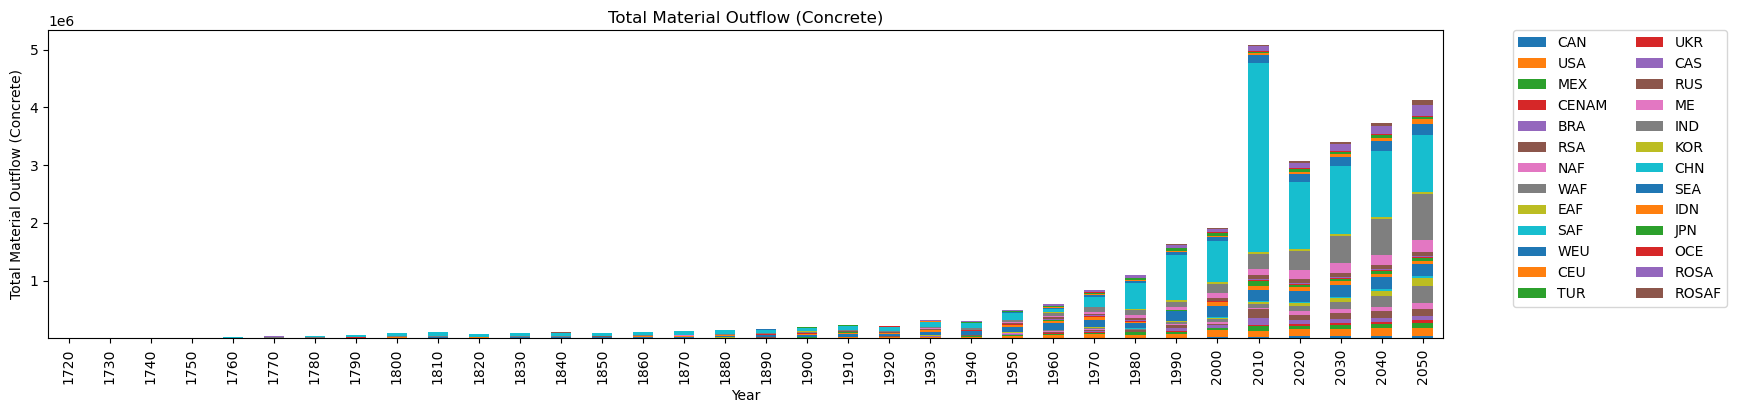

In [19]:
plot_tools.plot_database(sand_total_plot, 'Total Material Outflow (Concrete)', 'Total Material Outflow (Concrete)')